In [1]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator

# This script uses the export summary created by the OrchestraZ auto export application feature
#  to analyze the data


In [4]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/"
export_summary = data_dir + "export_summary.csv"

camera_program = 4
um_per_px = 6.0 #um

# Movie maker settings
enable_photoZ_interact = False
initialize_photoZ = False

In [7]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

# open export summary csv
df = pd.read_csv(export_summary)

# normalize latency
actual_stim_time = 48.9
df['latency'] = df['latency'] - actual_stim_time
df

,ROI,amp,latency,halfwidth,ROI_Set,Date,Slice,Location,Recording,snr_array
0,1,2.91594,0.5779,4.97997,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
1,2,4.06318,0.3830,3.77557,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
2,3,3.71713,0.5110,4.27915,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
3,4,3.24216,0.8073,4.43570,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
4,5,3.90170,0.1509,4.31240,1_2_1roi,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
...,...,...,...,...,...,...,...,...,...,...
265,4,1.39715,-3.5103,3.86293,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,7,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
266,1,2.66441,4.3184,3.53329,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
267,2,2.16470,-3.6988,4.80886,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
268,3,3.31798,-2.7124,3.39042,NaN,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,1,2,8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24
7/19/2024 2_1


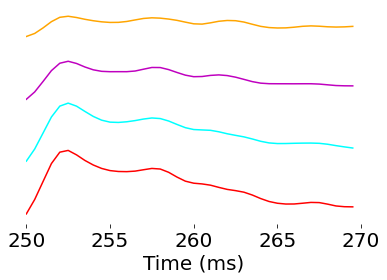

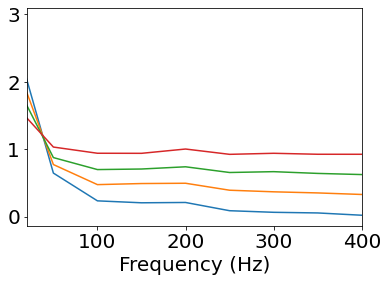

7/19/2024 2_1


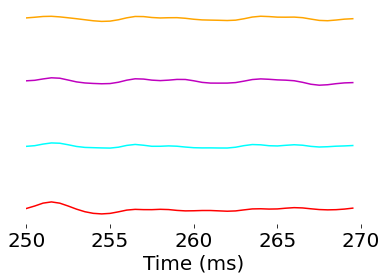

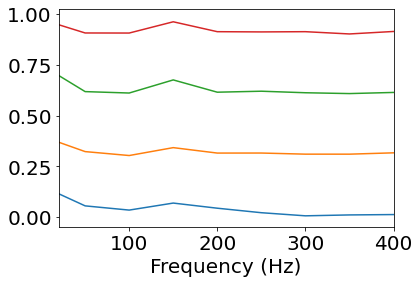

7/19/2024 2_1


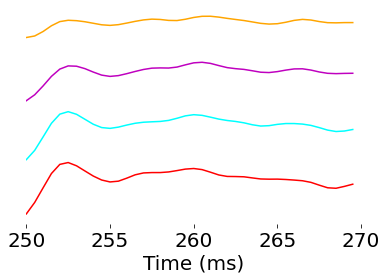

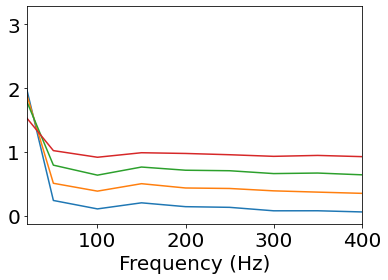

7/19/2024 2_1


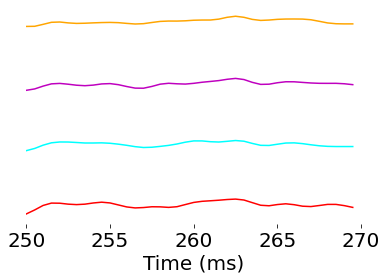

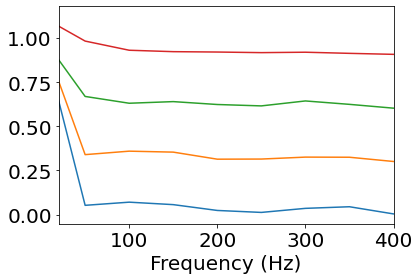

7/19/2024 2_1


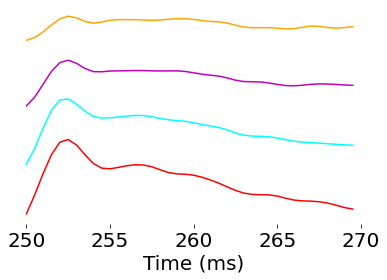

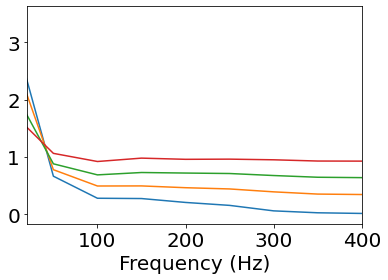

7/19/2024 2_1


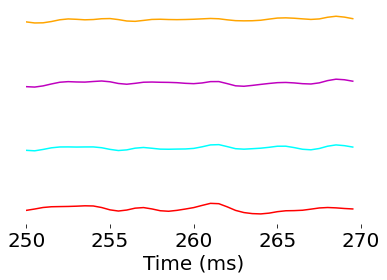

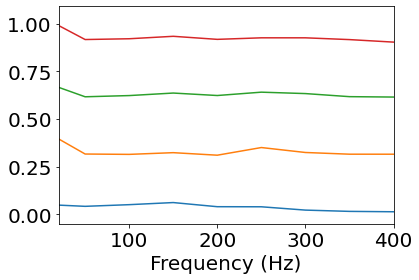

7/19/2024 2_1


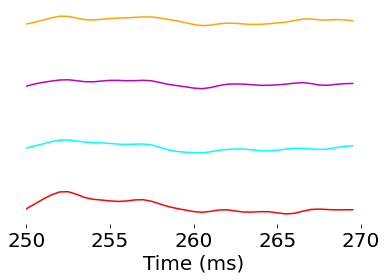

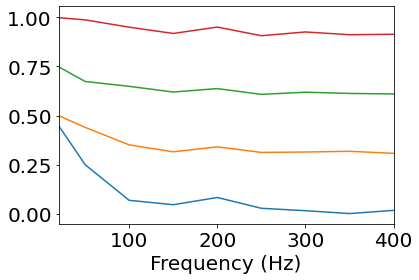

In [33]:
# plot traces
for date in df['Date'].unique():
    df_date = df[df['Date'] == date]
    for slic_id in df_date['Slice'].unique():
        df_slic = df_date[df_date['Slice'] == slic_id]
        for loc_id in df_slic['Location'].unique():
            df_loc = df_slic[df_slic['Location'] == loc_id]
            for rec_id in df_loc['Recording'].unique():
                df_rec = df_loc[df_loc['Recording'] == rec_id]
                for roi_id in df_rec['ROI'].unique():
                    df_roi = df_rec[df_rec['ROI'] == roi_id]
                    
                    for trace in traces_to_plot:
                        tm = TraceMetrics(trace)
                        print(date, slic_loc_id)
                        tm.show_traces(measure_window=[500, 540], 
                                legend=False, 
                                colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                        'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                                stim_time=248.3,
                                headroom=2,
                                        )
                        tm.frequency_decomposition(measure_window=[500, 540],
                                                   xlim=[20, 400])

[60, 70, 80, 100, 120, 200] 2
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta/07-19-24


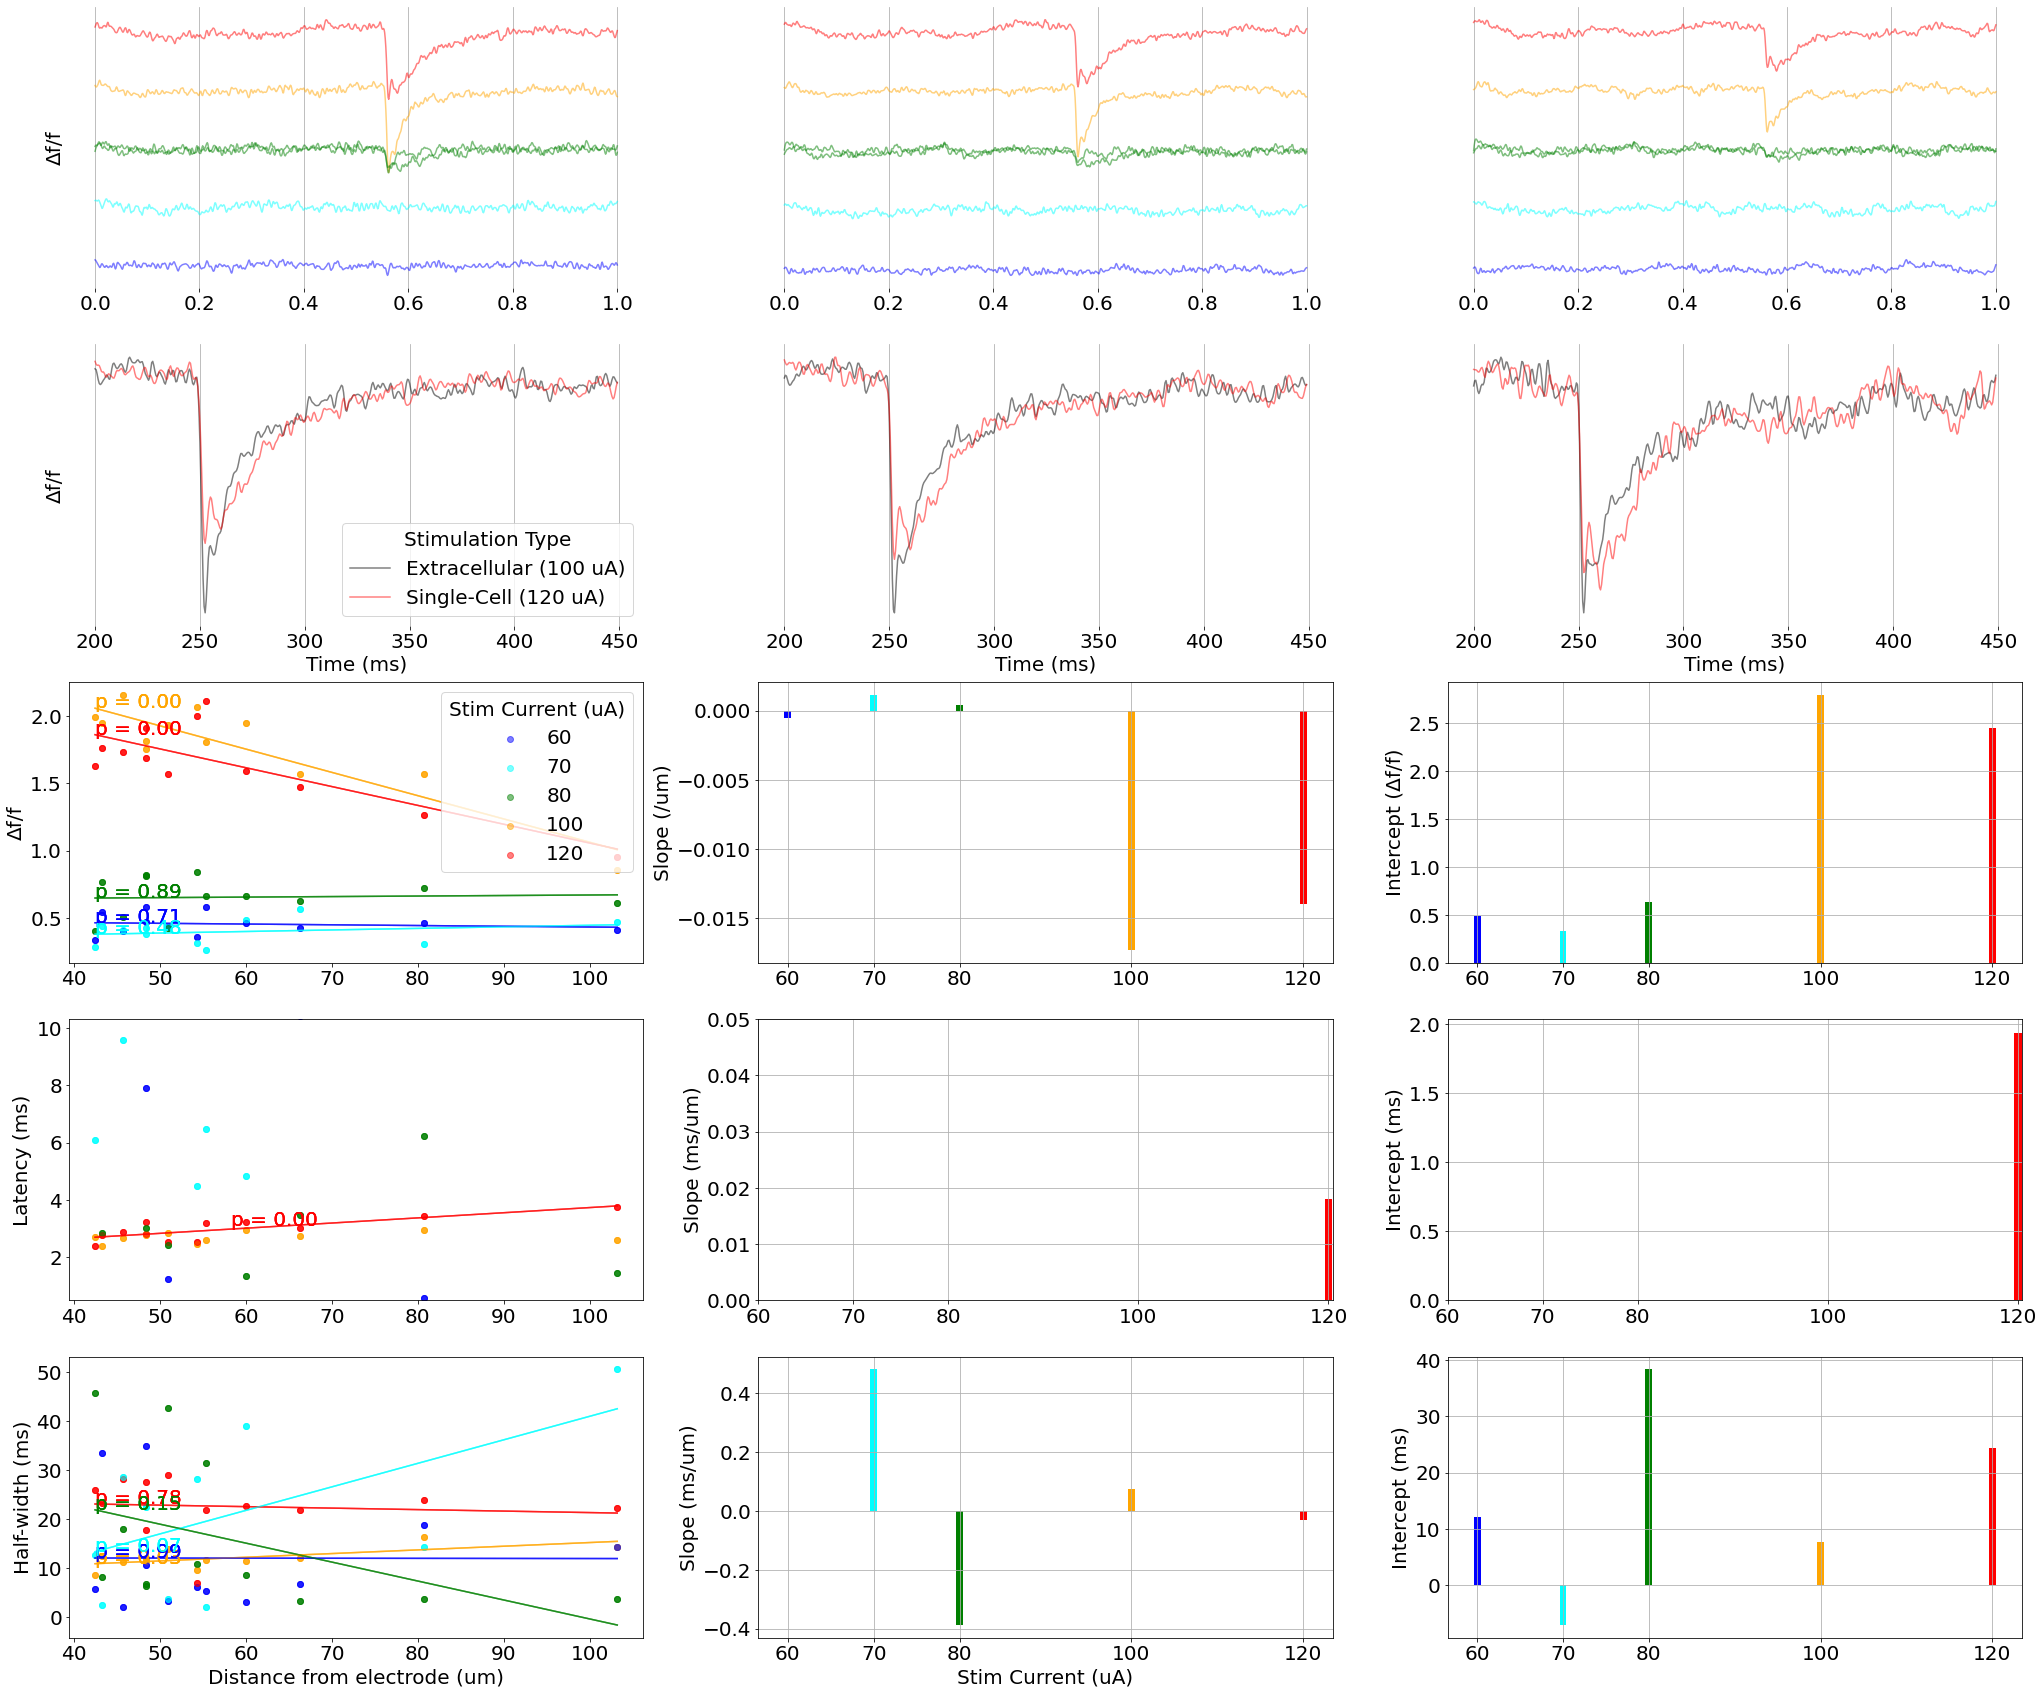

In [43]:
# set matplotlib font size to 16
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 3, figsize=(35, 30))

roi_type = 'non_soma'

# color list from cold to hot
stim_color_map = {
    60: 'blue',
    70: 'cyan',
    80: 'green',
    100: 'orange',
    120: 'red',
    200: 'magenta'
}
stim_legend = {}
stim_order = list(stim_color_map.keys())
stim_order.sort()
print(stim_order, stim_order.index(80))

ax[4, 0].set_xlabel("Distance from electrode (um)")
ax[4, 1].set_xlabel("Stim Current (uA)")
ax[3, 0].set_ylim(1.5, 3.3)
headroom = 1.8
for subdir in data_map:
    print(subdir)
    date = parse_date(subdir, long_year=True)
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            for roi_set_id in data_map[subdir][slic_id][loc_id]:
                if roi_set_id == 'stim_point_file' or roi_set_id == 'zda_files' or roi_set_id == 'roi_files':
                    continue
                    
                for i, zda_file in enumerate(data_map[subdir][slic_id][loc_id]['zda_files']): 
                    amp_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['amp'][i]
                    hw_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['hw'][i]
                    lat_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['lat'][i]
                    trace_filename = data_map[subdir][slic_id][loc_id][roi_set_id]['trace'][i]
                    sample_traces = read_traces_file(trace_filename)

                    # use catalog to tell what stim current was used
                    catalog_df_subset = catalog_df[(catalog_df['Date'] == date) &
                                                    (catalog_df['Slice'] == slic_id) &
                                                    (catalog_df['Loc'] == loc_id) & 
                                                    (catalog_df['Recording'] ==  i+1)]
                    stim_current = catalog_df_subset['Stim_Current'].values[0]
                    electrode_type = catalog_df_subset['Electrode_Type'].values[0]

                    if 'ring' in roi_set_id and electrode_type == 'single':
                        color = stim_color_map[stim_current]

                        # plot the first three traces in the 3 plots of the first row
                        for j, col_name in enumerate(sample_traces.columns[1:4]):
                            x = np.linspace(0, 1, len(sample_traces['Pt']))

                            y_loc = headroom * stim_order.index(stim_current)
                            ax[0, j].plot(x, -sample_traces[col_name] + y_loc, color=color, alpha=0.5)
                            ax[0, 0].set_ylabel("Δf/f")
                            ax[0, j].set_yticks([])
                            #ax[0, j].set_xlabel("Time (ms)")
                            ax[0, j].grid(True)
                            ax[0, j].spines['top'].set_visible(False)
                            ax[0, j].spines['right'].set_visible(False)
                            ax[0, j].spines['bottom'].set_visible(False)
                            ax[0, j].spines['left'].set_visible(False)


                    # plot latency vs distance, half-width vs distance, max-amp time, and amplitude vs distance
                    # each amplitude has a different color
                    if i == 3:
                        continue  # exclude recording because it is a duplicate 80 uA stim
                    subset_df = final_df[(final_df['Date'] == date) &
                                            (final_df['Slice'] == slic_id) &
                                            (final_df['Loc'] == loc_id) &
                                            (final_df['Recording'] == i+1) & 
                                            (final_df['Electrode_Type'] == 'single')]
                    
                    if roi_type == 'soma_non_soma':
                        subset_df2 = subset_df[(subset_df['ROI_Type'] == 'soma') | 
                                                (subset_df['ROI_Type'] == 'non_soma')]
                    elif roi_type == 'soma':
                        subset_df2 = subset_df[(subset_df['ROI_Type'] == 'soma')]
                    elif roi_type == 'non_soma':
                        subset_df2 = subset_df[(subset_df['ROI_Type'] == 'non_soma')]
                    elif roi_type == 'ring':
                        subset_df2 = subset_df[(subset_df['ROI_Type'] == 'ring')]

                    # scatter plot in the first column
                    for i_plotrow, response_type in enumerate(['Value', 'Value_lat', 'Value_hw']):
                        i_plotrow += 2
                        subset_df3 = subset_df2[(subset_df2[response_type] > 0) & 
                                                (subset_df2['Value'] > 0.03)]

                        for stim_current in subset_df3['Stim_Current'].unique():
                            subset_df4 = subset_df3[subset_df3['Stim_Current'] == stim_current]
                            if len(subset_df4) < 3:
                                continue
                            '''if response_type == 'Value_lat' and stim_current == 70:
                                continue

                            if response_type == 'Value_hw' and stim_current < 80:
                                continue'''

                            # 'subthreshold (≤80 uA)', 'suprathreshold (>80 uA)'
                            j_roi = 0  # if stim_current <= 80 else 1

                            
                            # linear regression for this stim current subset
                            slope, intercept, r_value, p_value, std_err = linregress(subset_df4['Distance'], subset_df4[response_type])
                            
                        
                            handle = ax[i_plotrow, j_roi].scatter(subset_df4['Distance'], subset_df4[response_type], 
                                                    color=stim_color_map[stim_current], 
                                                    label=subset_df4['Stim_Current'].values[0],
                                                    alpha=0.5)
                            if p_value > 0.1 and response_type == 'Value_lat':
                                continue
                            
                            # plot the linear regression line
                            x = np.linspace(min(subset_df4['Distance']), max(subset_df4['Distance']), 100)
                            y = slope * x + intercept
                            ax[i_plotrow, j_roi].plot(x, y, color=stim_color_map[stim_current], alpha=0.5)

                            # label the linear regression line with the slope and p-value

                            y_annotation = i * 1/7
                            x_annotation = .84
                            xyc = 'axes fraction'
                            if response_type == 'Value' or response_type == 'Value_hw':
                                y_annotation = slope * min(subset_df4['Distance']) + intercept
                                x_annotation = min(subset_df4['Distance']  )
                                xyc = 'data'
                            if response_type == 'Value_lat':
                                y_annotation = slope * np.mean(subset_df4['Distance']  ) + intercept + 0.1
                                x_annotation = np.mean(subset_df4['Distance']  )
                                xyc = 'data'

                            ax[i_plotrow, j_roi].annotate(f"p = {p_value:.2f}", 
                                                    (x_annotation, y_annotation),
                                                    color=stim_color_map[stim_current],
                                                    xycoords=xyc)

                            stim_legend[stim_current] = handle                            
                            ax[i_plotrow, 0].set_ylabel({'Value' : 'Δf/f', 
                                                        'Value_hw': 'Half-width (ms)', 
                                                        'Value_lat': 'Latency (ms)', 
                                                        'Max_Amp_Time': 'Time to peak (ms)'}[response_type])
                            
                            # in the 2nd column, plot slope vs stim current as a bar plot
                            if response_type == 'Value_lat':
                                ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                                ax[i_plotrow, 1].set_ylabel("Slope (ms/um)")
                                ax[i_plotrow, 1].set_ylim(0, 0.05)
                                ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 1].grid(True)
                            elif response_type == 'Value':
                                ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                                ax[i_plotrow, 1].set_ylabel("Slope (/um)")
                                ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 1].grid(True)
                            elif response_type == 'Value_hw':
                                ax[i_plotrow, 1].bar(stim_current, slope, color=stim_color_map[stim_current])
                                ax[i_plotrow, 1].set_ylabel("Slope (ms/um)")
                                ax[i_plotrow, 1].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 1].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 1].grid(True)

                            # in the last column, plot intercept vs stim current as a bar plot
                            if response_type == 'Value_lat':
                                ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                                ax[i_plotrow, 2].set_ylabel("Intercept (ms)")
                                ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 2].grid(True)
                            elif response_type == 'Value':
                                ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                                ax[i_plotrow, 2].set_ylabel("Intercept (Δf/f)")
                                ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 2].grid(True)
                            elif response_type == 'Value_hw':
                                ax[i_plotrow, 2].bar(stim_current, intercept, color=stim_color_map[stim_current])
                                ax[i_plotrow, 2].set_ylabel("Intercept (ms)")
                                ax[i_plotrow, 2].set_xticks(list(stim_legend.keys()))
                                ax[i_plotrow, 2].set_xticklabels(list(stim_legend.keys()))
                                ax[i_plotrow, 2].grid(True)
handle_keys = list(stim_legend.keys())
handle_keys.sort()
handles = [stim_legend[k] for k in handle_keys]
ax[2, 0].legend(handles=handles, title="Stim Current (uA)")

# for the last row, compare EC to TH at three distances
ec_trace = data_dir + "/07-19-24/selected_zda/ec_trace.dat"
th_trace = data_dir + "/07-19-24/selected_zda/th_trace.dat"
ec_trace_data = read_traces_file(ec_trace)
th_trace_data = read_traces_file(th_trace)

# th is in red, ec is in black
for i, col_name in enumerate(ec_trace_data.columns[1:4]):
    plot_start = 400
    x = ec_trace_data['Pt'] * 0.5
    l1 = ax[1, i].plot(x[plot_start:], -ec_trace_data[col_name][plot_start:], color='black', alpha=0.5)
    l2 = ax[1, i].plot(x[plot_start:], -th_trace_data[col_name][plot_start:], color='red', alpha=0.5)
    ax[1, i].set_xlabel("Time (ms)")
    ax[1, i].set_yticks([])
    ax[1, i].grid(True)
    ax[1, i].spines['top'].set_visible(False)
    ax[1, i].spines['right'].set_visible(False)
    ax[1, i].spines['bottom'].set_visible(False)
    ax[1, i].spines['left'].set_visible(False)
ax[1, 0].legend(handles=[l1[0], l2[0]], labels=['Extracellular (100 uA)', 'Single-Cell (120 uA)'], title="Stimulation Type")
ax[1, 0].set_ylabel("Δf/f")
ax[3, 0].set_ylim(0.5, 10.3)
plt.savefig("P:/John/crossing-paper/input/output-theta-" + roi_type + ".png")
plt.show()


                        

## 